# Assignment 8: CudaVision
------
### Group Members:
__1.__ Saikat Roy

__2.__ Albert Gubaidullin

__Please note that detailed architectures and results are available in the output with *readable* messages. Important things are summarized either in the Headings or in the text block below the heading.__

## Import Dependencies
------

In [0]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchsummary import summary

from matplotlib import pyplot as plt
device = torch.device('cuda:0')

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
!mkdir robot_football
!mkdir robot_football/data
!unzip robot_football -d robot_football/data

Archive:  robot_football.zip
 extracting: robot_football/data/football-001.jpg  
 extracting: robot_football/data/football-002.jpg  
 extracting: robot_football/data/football-003.jpg  
 extracting: robot_football/data/football-004.jpg  
 extracting: robot_football/data/football-005.jpg  
 extracting: robot_football/data/football-006.jpg  
 extracting: robot_football/data/football-007.jpg  
 extracting: robot_football/data/football-008.jpg  
 extracting: robot_football/data/football-009.jpg  
 extracting: robot_football/data/football-010.jpg  
 extracting: robot_football/data/football-011.jpg  
 extracting: robot_football/data/football-012.jpg  
 extracting: robot_football/data/football-013.jpg  
 extracting: robot_football/data/football-014.jpg  
 extracting: robot_football/data/football-015.jpg  
 extracting: robot_football/data/football-016.jpg  
 extracting: robot_football/data/football-017.jpg  
 extracting: robot_football/data/football-018.jpg  
 extracting: robot_football/data/fo

## Generator and Discriminator definition and loading
------

In [5]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(

            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.block(x)
        #print(x.size())
        return x


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            #nn.Dropout2d(0.2),
            nn.Conv2d(3, 16, kernel_size=(3,3),padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
 
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
 
            nn.Conv2d(32, 64, kernel_size=(3,3),padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=(3,3),padding=1, bias=False),            
            nn.AvgPool2d(kernel_size=(4,4)),
            #nn.Linear(512,2)
        )
        self.out = nn.Sequential(nn.Linear(256,1),nn.Sigmoid())

    def forward(self, x):
        x1 = self.block(x)
        x1 = x1.view(x.size(0),-1)
        x = self.out(x1)
        #print(x.size())
        return x

gen_model = Generator().to(device)
dis_model = Discriminator().to(device)


print(summary(gen_model, input_size=(100,1,1)))
print(summary(dis_model, input_size=(3,64,64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

## Dataloaders, Generate Image and Weight Initialization
------

In [0]:
def dataloaders(name, path=r"./robot_football"):
    transforms_list = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    
    if name == "mnist":
        os.makedirs('./data/mnist', exist_ok=True)
        dataset = datasets.MNIST('./data/mnist', train=False, download=True,
                       transform=transforms_list)
    elif name == "robot":
        dataset = datasets.ImageFolder(path, transforms_list)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

def generate_images(gen_model, epoch_no, batch_size=16):
    gen_inp = torch.randn(batch_size, 100, 1, 1, device=device)
    gen_inp = gen_inp.to(device)
    fake_images = gen_model(gen_inp)
    fake_images = fake_images.cpu().detach()
    show(make_grid(fake_images, nrow=4))

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize = (8,8))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect='auto')
    plt.show()


## Training the Generator and Discriminator
------



SAMPLE OF TRUE IMAGES..


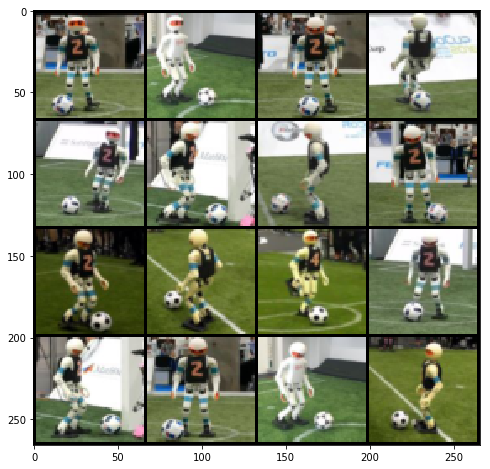

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 0
Generator and Discrimator average loss: 0.8557516792241264, 0.671816860928255
Current Discriminator Accuracy = 9.470588235294118
Current Discriminator Positives Accuracy = 2.9411764705882355
Current Discriminator Negatives Accuracy = 16.0
Current Generator Accuracy = 0.0


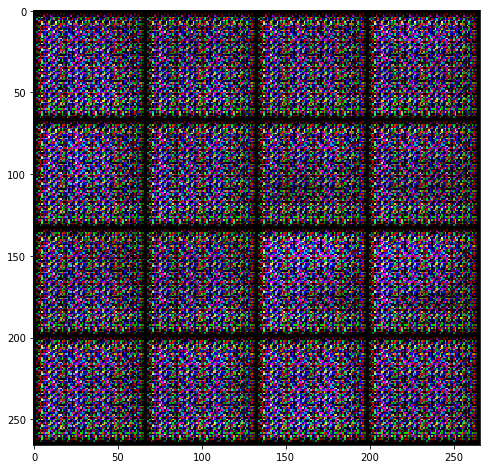

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 10
Generator and Discrimator average loss: 0.7985223847277024, 0.6360305126975564
Current Discriminator Accuracy = 13.5
Current Discriminator Positives Accuracy = 12.941176470588236
Current Discriminator Negatives Accuracy = 14.058823529411764
Current Generator Accuracy = 1.9411764705882353


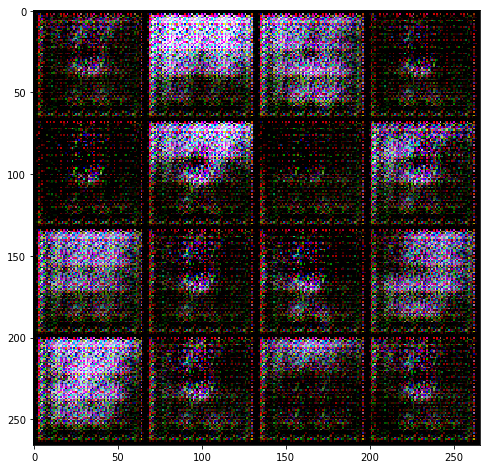

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 20
Generator and Discrimator average loss: 1.5060107146992403, 0.3378075939767501
Current Discriminator Accuracy = 15.794117647058822
Current Discriminator Positives Accuracy = 15.588235294117647
Current Discriminator Negatives Accuracy = 16.0
Current Generator Accuracy = 0.0


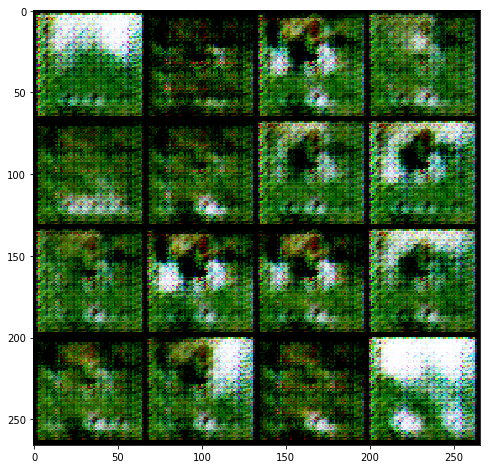

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 30
Generator and Discrimator average loss: 0.8228136932148653, 0.6789846174857196
Current Discriminator Accuracy = 10.823529411764707
Current Discriminator Positives Accuracy = 9.411764705882353
Current Discriminator Negatives Accuracy = 12.235294117647058
Current Generator Accuracy = 3.764705882352941


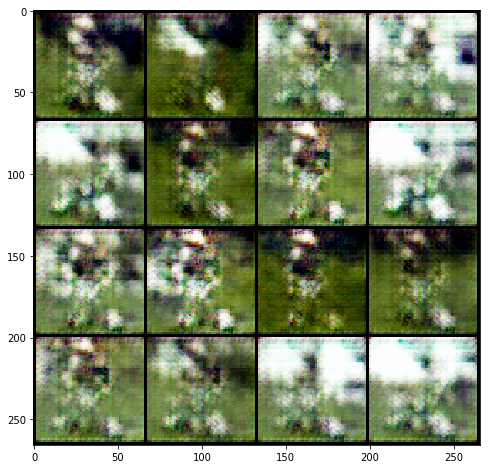

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 40
Generator and Discrimator average loss: 0.9500478435965145, 0.5932558249024784
Current Discriminator Accuracy = 13.0
Current Discriminator Positives Accuracy = 12.235294117647058
Current Discriminator Negatives Accuracy = 13.764705882352942
Current Generator Accuracy = 2.235294117647059


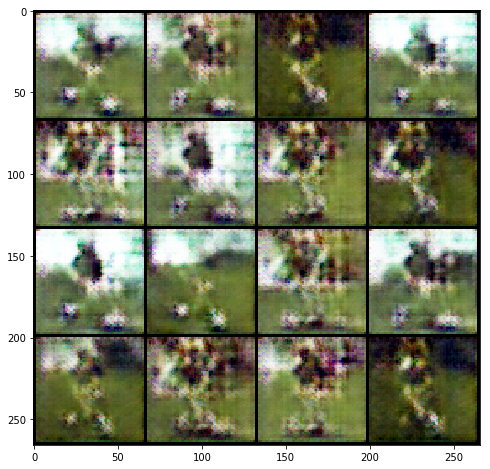

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 50
Generator and Discrimator average loss: 1.1466881843174206, 0.5125961514080272
Current Discriminator Accuracy = 14.235294117647058
Current Discriminator Positives Accuracy = 13.705882352941176
Current Discriminator Negatives Accuracy = 14.764705882352942
Current Generator Accuracy = 1.2352941176470589


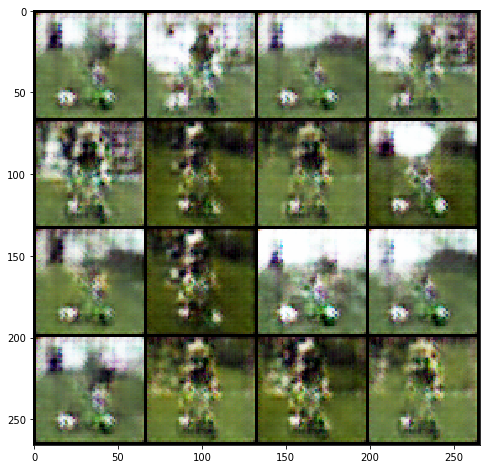

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 60
Generator and Discrimator average loss: 1.1299852132797241, 0.533926232772715
Current Discriminator Accuracy = 13.794117647058824
Current Discriminator Positives Accuracy = 13.823529411764707
Current Discriminator Negatives Accuracy = 13.764705882352942
Current Generator Accuracy = 2.235294117647059


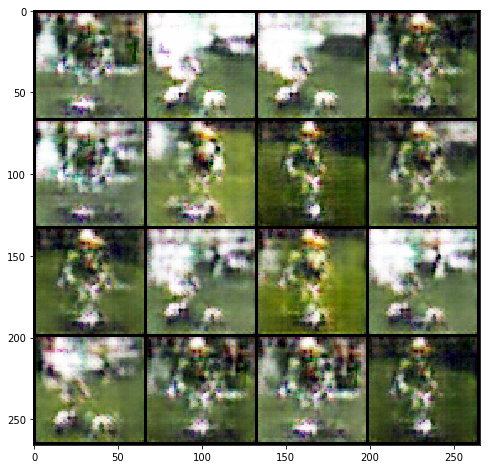

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 70
Generator and Discrimator average loss: 1.4098911636015947, 0.45502150584669676
Current Discriminator Accuracy = 14.294117647058824
Current Discriminator Positives Accuracy = 13.764705882352942
Current Discriminator Negatives Accuracy = 14.823529411764707
Current Generator Accuracy = 1.1764705882352942


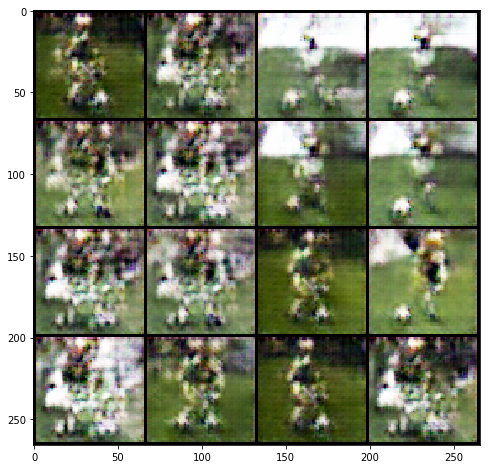

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 80
Generator and Discrimator average loss: 1.5244635764290304, 0.3970022604745977
Current Discriminator Accuracy = 14.617647058823529
Current Discriminator Positives Accuracy = 14.588235294117647
Current Discriminator Negatives Accuracy = 14.647058823529411
Current Generator Accuracy = 1.3529411764705883


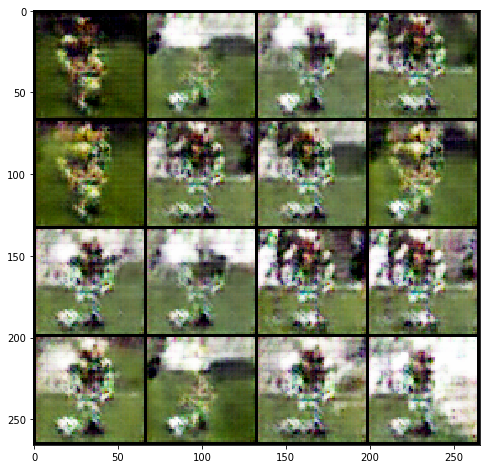

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 90
Generator and Discrimator average loss: 1.8828163146972656, 0.26907122135162354
Current Discriminator Accuracy = 15.735294117647058
Current Discriminator Positives Accuracy = 15.588235294117647
Current Discriminator Negatives Accuracy = 15.882352941176471
Current Generator Accuracy = 0.11764705882352941


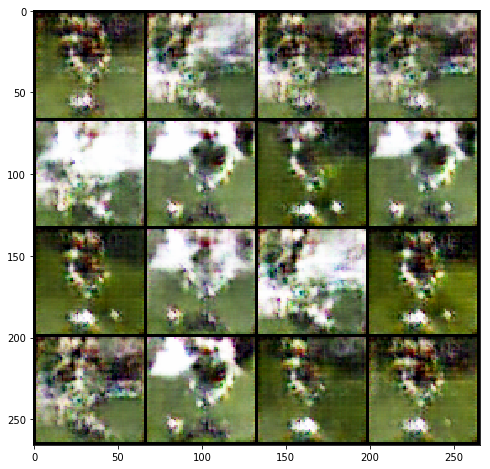

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 100
Generator and Discrimator average loss: 1.7425201219670914, 0.35898008153719063
Current Discriminator Accuracy = 15.0
Current Discriminator Positives Accuracy = 15.176470588235293
Current Discriminator Negatives Accuracy = 14.823529411764707
Current Generator Accuracy = 1.1764705882352942


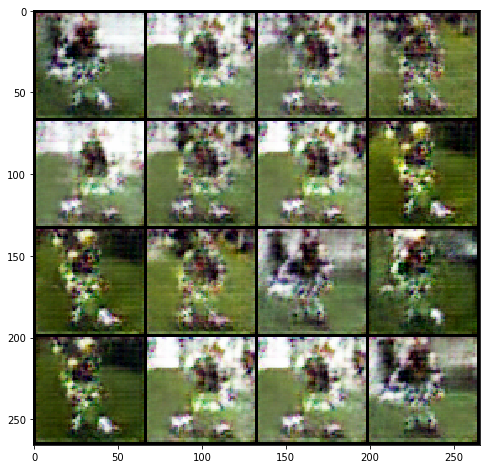

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 110
Generator and Discrimator average loss: 1.9216621342827291, 0.2996748878675349
Current Discriminator Accuracy = 15.264705882352942
Current Discriminator Positives Accuracy = 15.176470588235293
Current Discriminator Negatives Accuracy = 15.352941176470589
Current Generator Accuracy = 0.6470588235294118


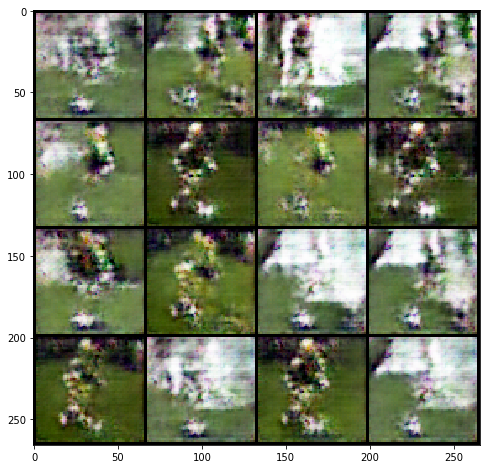

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 120
Generator and Discrimator average loss: 1.8837941183763391, 0.2975556552410126
Current Discriminator Accuracy = 15.147058823529411
Current Discriminator Positives Accuracy = 15.176470588235293
Current Discriminator Negatives Accuracy = 15.117647058823529
Current Generator Accuracy = 0.8823529411764706


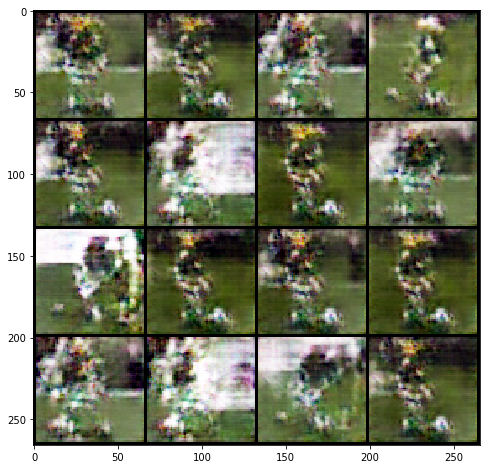

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 130
Generator and Discrimator average loss: 1.8435568739386166, 0.3382471782319686
Current Discriminator Accuracy = 14.735294117647058
Current Discriminator Positives Accuracy = 14.529411764705882
Current Discriminator Negatives Accuracy = 14.941176470588236
Current Generator Accuracy = 1.0588235294117647


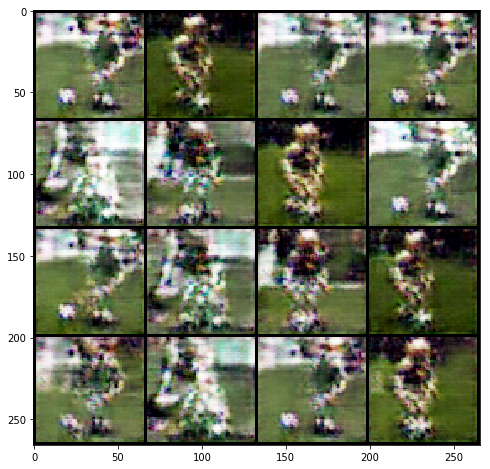

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 140
Generator and Discrimator average loss: 2.046511313494514, 0.3266478435081594
Current Discriminator Accuracy = 14.941176470588236
Current Discriminator Positives Accuracy = 15.0
Current Discriminator Negatives Accuracy = 14.882352941176471
Current Generator Accuracy = 1.1176470588235294


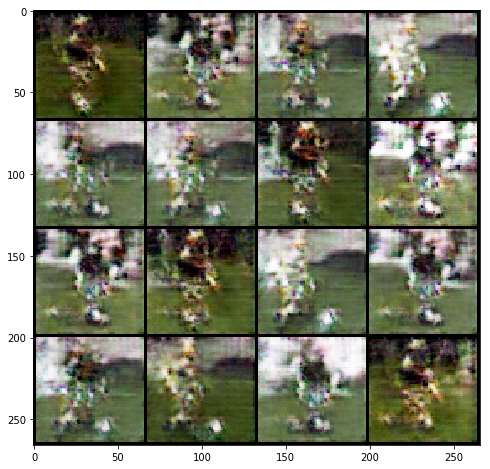

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 150
Generator and Discrimator average loss: 2.2592638345325695, 0.27332113244954276
Current Discriminator Accuracy = 15.117647058823529
Current Discriminator Positives Accuracy = 15.117647058823529
Current Discriminator Negatives Accuracy = 15.117647058823529
Current Generator Accuracy = 0.8823529411764706


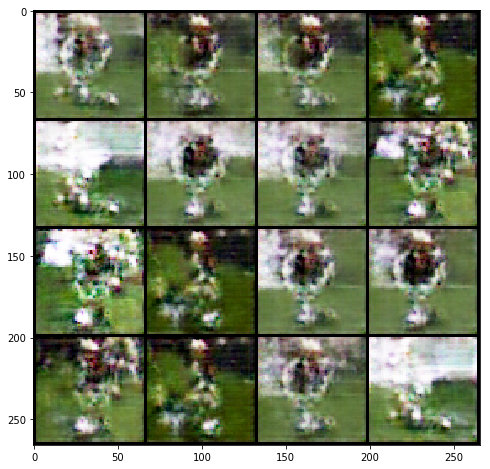

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 160
Generator and Discrimator average loss: 2.3168861024519978, 0.2025115884402219
Current Discriminator Accuracy = 15.705882352941178
Current Discriminator Positives Accuracy = 15.823529411764707
Current Discriminator Negatives Accuracy = 15.588235294117647
Current Generator Accuracy = 0.4117647058823529


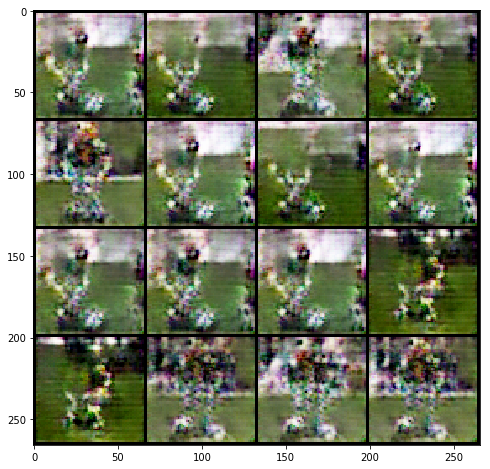

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 170
Generator and Discrimator average loss: 2.3217054079560673, 0.30052987924393487
Current Discriminator Accuracy = 15.323529411764707
Current Discriminator Positives Accuracy = 15.588235294117647
Current Discriminator Negatives Accuracy = 15.058823529411764
Current Generator Accuracy = 0.9411764705882353


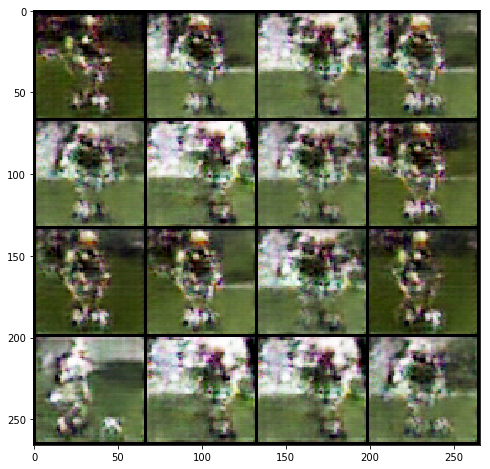

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 180
Generator and Discrimator average loss: 2.4760570806615494, 0.232058906379868
Current Discriminator Accuracy = 15.176470588235293
Current Discriminator Positives Accuracy = 15.470588235294118
Current Discriminator Negatives Accuracy = 14.882352941176471
Current Generator Accuracy = 1.1176470588235294


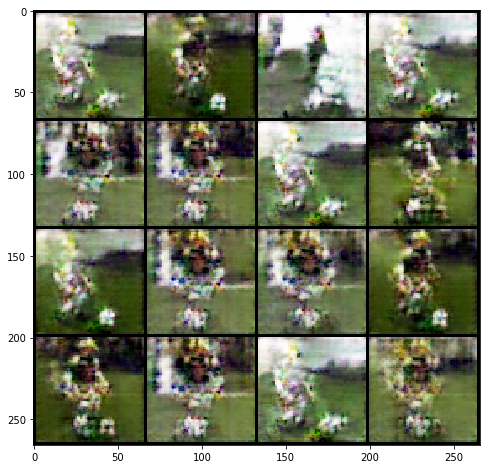

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 190
Generator and Discrimator average loss: 2.3284317044650806, 0.29636233738240075
Current Discriminator Accuracy = 15.029411764705882
Current Discriminator Positives Accuracy = 15.176470588235293
Current Discriminator Negatives Accuracy = 14.882352941176471
Current Generator Accuracy = 1.1176470588235294


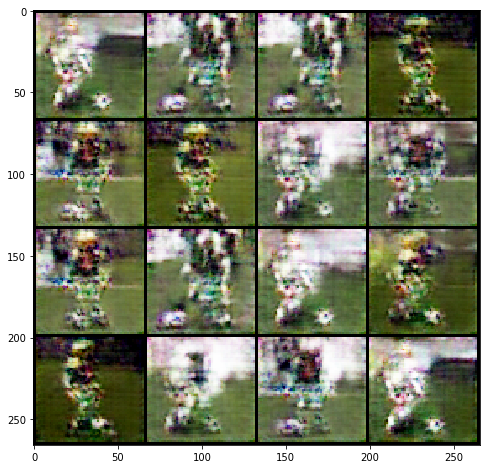

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 200
Generator and Discrimator average loss: 2.2611468820010914, 0.31008070707321167
Current Discriminator Accuracy = 15.411764705882353
Current Discriminator Positives Accuracy = 15.529411764705882
Current Discriminator Negatives Accuracy = 15.294117647058824
Current Generator Accuracy = 0.7058823529411765


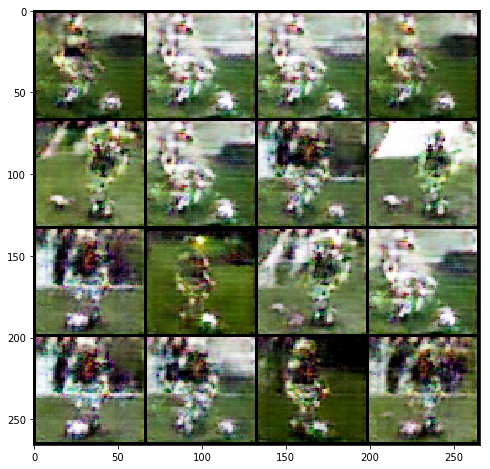

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 210
Generator and Discrimator average loss: 2.486358270925634, 0.27591866956037636
Current Discriminator Accuracy = 15.352941176470589
Current Discriminator Positives Accuracy = 15.411764705882353
Current Discriminator Negatives Accuracy = 15.294117647058824
Current Generator Accuracy = 0.7058823529411765


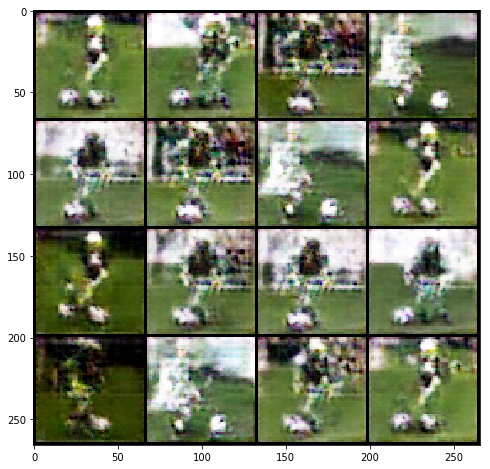

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 220
Generator and Discrimator average loss: 2.445651187616236, 0.23959036609705756
Current Discriminator Accuracy = 15.264705882352942
Current Discriminator Positives Accuracy = 15.823529411764707
Current Discriminator Negatives Accuracy = 14.705882352941176
Current Generator Accuracy = 1.2941176470588236


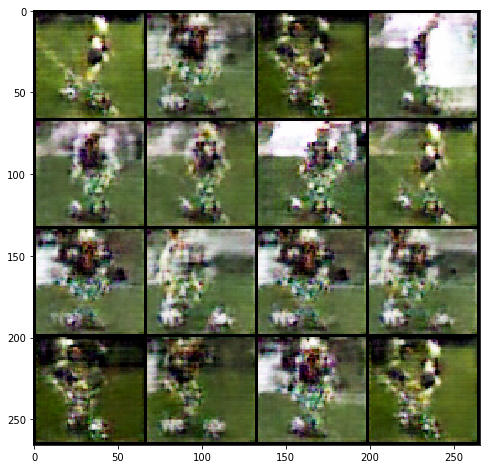

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 230
Generator and Discrimator average loss: 2.540599493419423, 0.2984964610899196
Current Discriminator Accuracy = 14.882352941176471
Current Discriminator Positives Accuracy = 15.176470588235293
Current Discriminator Negatives Accuracy = 14.588235294117647
Current Generator Accuracy = 1.411764705882353


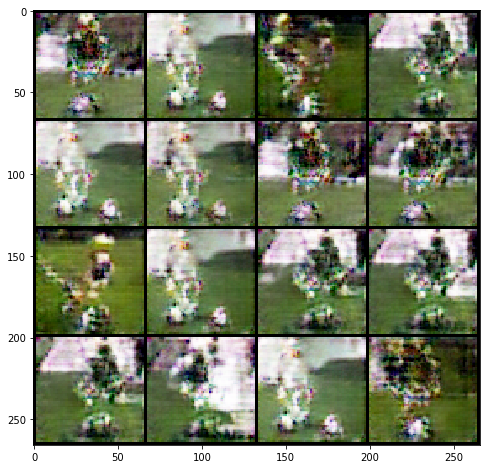

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLES OF GENERATED IMAGES..
Epoch 240
Generator and Discrimator average loss: 2.5814660086351284, 0.2533101430710624
Current Discriminator Accuracy = 15.411764705882353
Current Discriminator Positives Accuracy = 15.411764705882353
Current Discriminator Negatives Accuracy = 15.411764705882353
Current Generator Accuracy = 0.5882352941176471


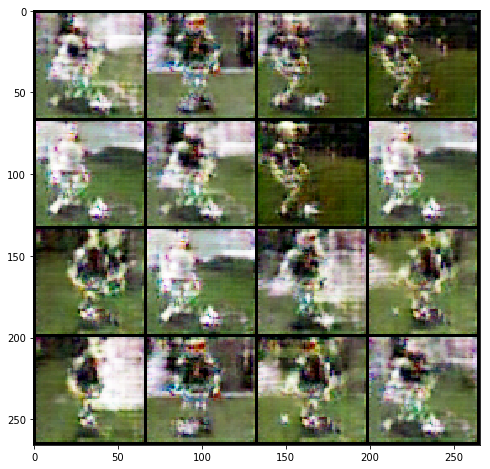

In [24]:
if __name__ == "__main__":

    image_size = 64
    batch_size = 16
    n_epochs = 250

    gen_lr = 1e-3
    dis_lr = 1e-4

    gen_model = Generator().to(device)
    dis_model = Discriminator().to(device)

    optimizer_gen = optim.Adam(gen_model.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    optimizer_dis = optim.Adam(dis_model.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    true_labels = 0.0   # CHANGE TO ZERO TO FLIP LABELS
    
    d_true_labels = Variable(torch.Tensor(batch_size).fill_(true_labels), requires_grad=False).to(device)
    g_labels = Variable(torch.Tensor(batch_size).fill_(1.0-true_labels), requires_grad=False).to(device)
      
    place_holder_true = np.ones([batch_size]) * true_labels
    place_holder_false = np.ones([batch_size]) * (1.0-true_labels)

    loss = nn.BCELoss().to(device)

    loss_list = []

    disc_dataloader = dataloaders("robot")

    for epoch in range(n_epochs):

        total = len(disc_dataloader) * batch_size * 2
        correct_pos = 0.0
        correct_neg = 0.0
        gen_acc = 0.0

        disc_loss_epoch = 0
        gen_loss_epoch = 0

        #for batch_id, (true_images,_) in enumerate(disc_dataloader, 0): # For MNIST Example
        for batch_id, (true_images,_) in enumerate(disc_dataloader, 0):
            if epoch==0 and batch_id == 0:
              sample_true = true_images
            gen_model.train()
            dis_model.train()

            optimizer_dis.zero_grad()
            gen_inp_1 = torch.randn(batch_size, 100, 1, 1, device=device, requires_grad=False)

            # gen_inp = gen_inp.to(device)
            fake_images = gen_model(gen_inp_1)
            # TRAINING DISCRIMINATOR

            true_images = true_images.to(device)
            
            d_true_loss = loss(dis_model(true_images).view(-1), d_true_labels)
            d_fake_loss = loss(dis_model(fake_images.detach()).view(-1), g_labels)  # Have to detach from graph for some reason

            d_loss = (d_true_loss + d_fake_loss) / 2

            d_true_loss.backward()
            d_fake_loss.backward()
            optimizer_dis.step()

            # TRAINING GENERATOR
            optimizer_gen.zero_grad()

            # CREATING A BATCH OF RANDOM NOISE IN [0,1] FOR GENERATOR INPUT
            gen_loss = loss(dis_model(fake_images).view(-1), d_true_labels)
            gen_loss.backward()
            optimizer_gen.step()

            gen_loss_epoch += gen_loss.item()
            disc_loss_epoch += d_loss.item()

            with torch.no_grad():
                outputs = dis_model(true_images)
                predicted = (outputs > 0.5).to("cpu").numpy()
                batch_disc_acc = (predicted == place_holder_true).sum()/batch_size
                correct_pos += (predicted == place_holder_true).sum()

                outputs = dis_model(fake_images.detach())
                predicted = (outputs > 0.5).to("cpu").numpy()
                correct_neg += (predicted == place_holder_false).sum()

                outputs = dis_model(fake_images.detach())
                predicted = (outputs > 0.5).to("cpu").numpy()
                batch_gen_acc = (predicted == place_holder_true).sum()/batch_size
                gen_acc += (predicted == place_holder_true).sum()

        correct_pos/=total
        correct_neg/=total
        gen_acc/=(total / 2)

        
        loss_list.append((gen_loss_epoch/len(disc_dataloader),disc_loss_epoch/len(disc_dataloader)))
        
        if epoch==0:
          print("SAMPLE OF TRUE IMAGES..")
          true_images = sample_true.cpu().detach()
          show(make_grid(true_images, nrow=4))
          
        if epoch%10==0:
          print("SAMPLES OF GENERATED IMAGES..")
          print("Epoch {}".format(epoch))
          print("Generator and Discrimator average loss: {}, {}".
              format(gen_loss_epoch / len(disc_dataloader), disc_loss_epoch / len(disc_dataloader)))
          print("Current Discriminator Accuracy = {}".format(correct_pos+correct_neg))
          print("Current Discriminator Positives Accuracy = {}".format(correct_pos*2))
          print("Current Discriminator Negatives Accuracy = {}".format(correct_neg*2))
          print("Current Generator Accuracy = {}".format(gen_acc))
          generate_images(gen_model, epoch, 16)
